## Create water mask for later training the model
To generate the ground truth images we use the <code>create_gt</code> module. An example of the floodmap image retrieved for the flood in Sardinia, is shown. 

In [23]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

import numpy as np
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from src.data import ee_download
from src.data.copernicusEMS import activations
from rasterio.plot import show as rasterio_show

from src.data import create_gt
from src.data.utils import GCPPath, read_pickle_from_gcp, get_files_in_directory_gcp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Stuff

In [25]:
ALL_JRC_FILES = get_files_in_directory_gcp("ml4cc_data_lake", "0_DEV/1_Staging/WorldFloods/JRC")
ALL_S2_FILES = get_files_in_directory_gcp("ml4cc_data_lake", "0_DEV/1_Staging/WorldFloods/S2")

len(ALL_JRC_FILES), len(ALL_S2_FILES)

SIM_FILES = list(filter(lambda x: x if str(Path(x))))

(60, 108)

In [2]:
# S2
S2_IMG_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/S2/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"


### Demo S2 Image

(2928, 6107)


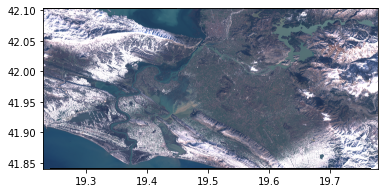

In [21]:
import rasterio
from rasterio import plot as rasterioplt
import numpy as np
import matplotlib.pyplot as plt



fig, ax = plt.subplots()
with rasterio.open(S2_IMG_PATH) as src:
    print(src.shape)
    image = src.read()
    transform = src.transform
    rgb = np.clip(image[(3,2,1),...]/3000.,0,1)
    
    rasterioplt.show(rgb, transform=transform, ax=ax)
    fig.savefig("./temp_s2.png")

## JRC Image

In [4]:
# permanent water
JRC_IMG_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/JRC/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"

(2928, 6107)


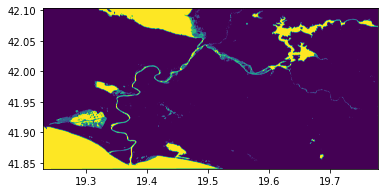

In [22]:
fig, ax = plt.subplots()

with rasterio.open(JRC_IMG_PATH) as src:
    print(src.shape)
#     image = src.read()
    transform = src.transform
    rasterioplt.show(src, transform=transform, ax=ax)
    fig.savefig("./temp_jrc.png")

## Floodmaps

In [6]:

# Flood Meta Path
FLOOD_META_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/flood_meta/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1_metadata_floodmap.pickle"
floodmap_meta = read_pickle_from_gcp(FLOOD_META_PATH)

# FloodMap Path
FLOODMAP_PATH = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/floodmap/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1_floodmap.geojson"



### Demo Image

In [7]:
import geopandas as gpd


floodmap_df = gpd.read_file(FLOODMAP_PATH)

# floodmap_df['geometry'].plot()


## Ground Truth!

### WorldFloods 1.1

In [8]:
from src.data.create_gt import generate_water_cloud_binary_gt, generate_land_water_cloud_gt

#### Create The Ground Truth

In [9]:
gt, gt_meta = generate_land_water_cloud_gt(                        
    S2_IMG_PATH,
    FLOODMAP_PATH,
    keep_streams=True,
    cloudprob_in_lastband=True,
    permanent_water_image_path=JRC_IMG_PATH,
)

/home/jemanjohnson34/software/miniconda3/envs/ml4fl_py38/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 853 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


#### Demo Image

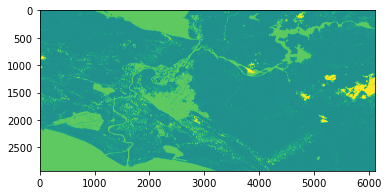

<AxesSubplot:>

In [10]:
rasterio_show(gt,vmin=-1, vmax=3)

## WorldFlood 2.0

In [11]:
from src.data.create_gt import generate_water_cloud_binary_gt

In [12]:
%%time

gt_binary, gt_meta_binary = generate_water_cloud_binary_gt(                        
    S2_IMG_PATH,
    FLOODMAP_PATH,
    metadata_floodmap=floodmap_meta,
    keep_streams=True,
    cloudprob_in_lastband=True,
    permanent_water_image_path=JRC_IMG_PATH,
)

CPU times: user 26.4 s, sys: 1.52 s, total: 27.9 s
Wall time: 51 s


#### Demo - Cloud Mask

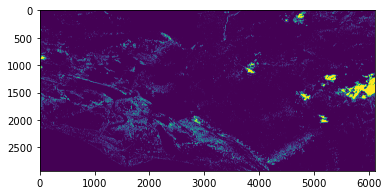

<Figure size 432x288 with 0 Axes>

In [19]:
rasterio_show(gt_binary[0])
plt.savefig("./temp_cloudm.png")

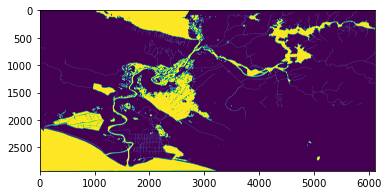

<Figure size 432x288 with 0 Axes>

In [20]:
rasterio_show(gt_binary[1])
plt.savefig("./temp_waterm.png")